In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
import requests
import statsmodels.formula.api as sm

In [676]:
n_samples = all2013.shape[0]
all2013.head()

,Unnamed: 0,Unnamed: 0_x,AWAY_PLAYER1_ID,AWAY_PLAYER2_ID,AWAY_PLAYER3_ID,AWAY_PLAYER4_ID,AWAY_PLAYER5_ID,AWAY_TEAM_ID,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,HOME_PLAYER1_ID,HOME_PLAYER2_ID,HOME_PLAYER3_ID,HOME_PLAYER4_ID,HOME_PLAYER5_ID,HOME_TEAM_ID,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD_x,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ABBREVIATION,PLAYER1_TEAM_CITY,PLAYER1_TEAM_ID,PLAYER1_TEAM_NICKNAME,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ABBREVIATION,PLAYER2_TEAM_CITY,PLAYER2_TEAM_ID,PLAYER2_TEAM_NICKNAME,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING,ACTION_BEFORE,Unnamed: 0_y,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,DRIBBLES,FGM,FINAL_MARGIN,GAME_CLOCK,GAME_ID.1,LOCATION,MATCHUP,PERIOD_y,PERIOD.1,PTS,PTS_TYPE,SHOT_CLOCK,SHOT_DIST,SHOT_NUMBER,SHOT_RESULT,TOUCH_TIME,W,GRID_TYPE,GAME_EVENT_ID,PLAYER_ID,PLAYER_ID.1,PLAYER_NAME,TEAM_ID,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,off_height,def_height,EVENT_NUM
0,0,2,2749,101131,201167,202696,203090,1610612753,1,2,2,21300001,MISS West 6' Jump Shot,2561,201579,201588,202331,202362,1610612754,NaN,11:39,1,4,0,0,2561,David West,IND,Indiana,1610612754,Pacers,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7:12 PM,10,0,"Maxiell, Jason",101131,1.6,2,0,10,11:41,21300001,H,"OCT 29, 2013 - IND vs. ORL",1,1,0,2,6.7,7.4,1,missed,7.8,W,Shot Chart Detail,2,2561,2561,David West,1610612754,11,39,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,5,-38,45,1,0,6-9,6-7,2
1,1,470,2749,101131,201167,202696,203090,1610612753,79,1,5,21300001,George 19' Pullup Jump Shot (2 PTS),2561,201579,201588,202331,202362,1610612754,NaN,11:30,1,4,0,0,202331,Paul George,IND,Indiana,1610612754,Pacers,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0 - 2,2,NaN,7:13 PM,6,0,"Harkless, Maurice",203090,4.1,1,1,10,11:32,21300001,H,"OCT 29, 2013 - IND vs. ORL",1,1,2,2,16.8,19.3,1,made,3.2,W,Shot Chart Detail,5,202331,202331,Paul George,1610612754,11,30,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,19,105,164,1,1,6-9,6-9,5
2,2,471,2749,101131,201167,202696,203090,1610612753,1,2,6,21300001,NaN,2561,201579,201588,202331,202362,1610612754,NaN,11:15,1,5,0,0,201167,Arron Afflalo,ORL,Orlando,1610612753,Magic,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISS Afflalo 27' 3PT Jump Shot,7:13 PM,1,0,"George, Paul",202331,4.4,0,0,-10,11:18,21300001,A,"OCT 29, 2013 - ORL @ IND",1,1,0,3,13.0,24.5,1,missed,0.7,L,Shot Chart Detail,6,201167,201167,Arron Afflalo,1610612753,11,15,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,27,51,266,1,0,6-5,6-9,6
3,3,473,2749,101131,201167,202696,203090,1610612753,5,2,8,21300001,MISS West 3' Layup,2561,201579,201588,202331,202362,1610612754,NaN,11:03,1,4,0,5,2561,David West,IND,Indiana,1610612754,Pacers,0,NaN,NaN,NaN,NaN,NaN,101131,Jason Maxiell,ORL,Orlando,1610612753,Magic,NaN,NaN,Maxiell BLOCK (1 BLK),7:13 PM,4,1,"Maxiell, Jason",101131,0.4,0,0,10,11:05,21300001,H,"OCT 29, 2013 - IND vs. ORL",1,1,0,2,13.8,1.4,2,missed,1.8,W,Shot Chart Detail,8,2561,2561,David West,1610612754,11,3,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,28,-5,1,0,6-9,6-7,8
4,4,11,2749,101131,201167,202696,203090,1610612753,1,1,11,21300001,Stephenson 26' 3PT Jump Shot (3 PTS) (West 1 AST),2561,201579,201588,202331,202362,1610612754,NaN,10:51,1,4,4,0,202362,Lance Stephenson,IND,Indiana,1610612754,Pacers,2561,David West,IND,Indiana,1610612754,Pacers,0,NaN,NaN,NaN,NaN,NaN,0 - 5,5,NaN,7:14 PM,5,0,"Nelson, Jameer",2749,5.7,0,1,10,10:53,21300001,H,"OCT 29, 2013 - IND vs. ORL",1,1,3,3,15.6,25.1,1,made,0.7,W,Shot Chart Detail,11,202362,202362,Lance Stephenson,1610612754,10,51,Made Shot,Jump Sh

In [298]:
plt.hist(np.log(1+all2013['DRIBBLES']))
plt.show()

In [96]:
##Prep for 2014 data
all2014=pd.read_csv('merged_shots/merged_shots_14.csv')
all2014['OFF_HEIGHT']=[np.nan if str(x) == 'nan' else int(str(x)[0])*12 + int(str(x)[2:]) for x in all2014.off_height]
all2014['DEF_HEIGHT']=[np.nan if str(x) == 'nan' or str(x) == '0'  else int(str(x)[0])*12 + int(str(x)[2:]) for x in all2014.def_height]
all2014['HEIGHT_DIFF'] = all2014['OFF_HEIGHT'] - all2014['DEF_HEIGHT']
y_test=all2014['SHOT_MADE_FLAG']
all2014['SHOT_CLOCK_ADJ']=60*all2014.MINUTES_REMAINING+all2014.SECONDS_REMAINING
all2014['SHOT_CLOCK_REAL']=[b if np.isnan(a) else a for a,b in zip(all2014['SHOT_CLOCK'],all2014['SHOT_CLOCK_ADJ'])]
all2014['FAST_BREAK_OFF_TURN']=[1 if ((x==5) & (z>18)) else 0 for x,z in zip(all2014.ACTION_BEFORE,all2014.SHOT_CLOCK_REAL)]
all2014['JUMP_SHOT']=[1 if x=='Jump Shot' else 0 for x in all2014.ACTION_TYPE]
X_test=all2014[['SHOT_CLOCK_REAL','JUMP_SHOT','CLOSE_DEF_DIST','DRIBBLES','TOUCH_TIME','SHOT_DISTANCE','OFF_HEIGHT','DEF_HEIGHT','HEIGHT_DIFF','FAST_BREAK_OFF_TURN']]
X_test['SHOT_DISTxCLOSE_DEF_DIST'] = X_test['SHOT_DISTANCE']*X_test['CLOSE_DEF_DIST']
X_test['CS']=X_test['DRIBBLES']==0
X_test['VERY_EARLY']=X_test.SHOT_CLOCK_REAL>23
X_test['EARLY']=(X_test.SHOT_CLOCK_REAL<=23)&(X_test.SHOT_CLOCK_REAL>18)
X_test['MID']=(X_test.SHOT_CLOCK_REAL<=18)&(X_test.SHOT_CLOCK_REAL>5)
X_test['LATE']=(X_test.SHOT_CLOCK_REAL<=5)
"""zone = pd.get_dummies(all2014['SHOT_ZONE_AREA']).ix[:,1:]
period = pd.get_dummies(all2014['PERIOD_y']).ix[:,1:]
#action = pd.get_dummies(all2014['ACTION_TYPE']).ix[:,1:]
zonebasic = pd.get_dummies(all2014['SHOT_ZONE_BASIC']).ix[:,1:]
shotrange = pd.get_dummies(all2014['SHOT_ZONE_RANGE']).ix[:,1:]
location = pd.get_dummies(all2014['LOCATION']).ix[:,1:]
#X_test=X_test.join(zone.join(period.join(zonebasic.join(shotrange.join(location.join(action))))))
X_test=X_test.join(zone.join(period.join(zonebasic.join(shotrange.join(location)))))
print pd.get_dummies(all2014['SHOT_ZONE_AREA']).columns[0],pd.get_dummies(all2014['PERIOD_y']).columns[0],pd.get_dummies(all2014['ACTION_TYPE']).columns[0],pd.get_dummies(all2014['SHOT_ZONE_BASIC']).columns[0],pd.get_dummies(all2014['SHOT_ZONE_RANGE']).columns[0],pd.get_dummies(all2014['LOCATION']).columns[0]"""

/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documen

"zone = pd.get_dummies(all2014['SHOT_ZONE_AREA']).ix[:,1:]\nperiod = pd.get_dummies(all2014['PERIOD_y']).ix[:,1:]\n#action = pd.get_dummies(all2014['ACTION_TYPE']).ix[:,1:]\nzonebasic = pd.get_dummies(all2014['SHOT_ZONE_BASIC']).ix[:,1:]\nshotrange = pd.get_dummies(all2014['SHOT_ZONE_RANGE']).ix[:,1:]\nlocation = pd.get_dummies(all2014['LOCATION']).ix[:,1:]\n#X_test=X_test.join(zone.join(period.join(zonebasic.join(shotrange.join(location.join(action))))))\nX_test=X_test.join(zone.join(period.join(zonebasic.join(shotrange.join(location)))))\nprint pd.get_dummies(all2014['SHOT_ZONE_AREA']).columns[0],pd.get_dummies(all2014['PERIOD_y']).columns[0],pd.get_dummies(all2014['ACTION_TYPE']).columns[0],pd.get_dummies(all2014['SHOT_ZONE_BASIC']).columns[0],pd.get_dummies(all2014['SHOT_ZONE_RANGE']).columns[0],pd.get_dummies(all2014['LOCATION']).columns[0]"

In [162]:
all2013=pd.read_csv('merged_shots/merged_shots_13.csv')
all2013['OFF_HEIGHT']=[np.nan if str(x) == 'nan' else int(str(x)[0])*12 + int(str(x)[2:]) for x in all2013.off_height]
all2013['DEF_HEIGHT']=[np.nan if str(x) == 'nan' else int(str(x)[0])*12 + int(str(x)[2:]) for x in all2013.def_height]
all2013['HEIGHT_DIFF'] = all2013['OFF_HEIGHT'] - all2013['DEF_HEIGHT']
y=all2013['SHOT_MADE_FLAG']
all2013['SHOT_CLOCK_ADJ']=60*all2013.MINUTES_REMAINING+all2013.SECONDS_REMAINING
all2013['SHOT_CLOCK_REAL']=[b if np.isnan(a) else a for a,b in zip(all2013['SHOT_CLOCK'],all2013['SHOT_CLOCK_ADJ'])]
all2013['FAST_BREAK_OFF_TURN']=[1 if ((x==5) & (z>18)) else 0 for x,z in zip(all2013.ACTION_BEFORE,all2013.SHOT_CLOCK_REAL)]
all2013['JUMP_SHOT']=[1 if x=='Jump Shot' else 0 for x in all2013.ACTION_TYPE]
X=all2013[['SHOT_CLOCK_REAL','JUMP_SHOT','CLOSE_DEF_DIST','DRIBBLES','TOUCH_TIME','SHOT_DISTANCE','HEIGHT_DIFF','FAST_BREAK_OFF_TURN']]
X['SHOT_DISTxCLOSE_DEF_DIST'] = X['SHOT_DISTANCE']*X['CLOSE_DEF_DIST']
X['HEIGHTxCLOSE_DEF_DIST'] = X['HEIGHT_DIFF']*X['CLOSE_DEF_DIST']
X['SHOT_DISTxJUMP_SHOT']=X['SHOT_DISTANCE']*X['JUMP_SHOT']
X['CS']=X['DRIBBLES']==0
X['VERY_EARLY']=X.SHOT_CLOCK_REAL>23
X['EARLY']=(X.SHOT_CLOCK_REAL<=23)&(X.SHOT_CLOCK_REAL>18)
X['MID']=(X.SHOT_CLOCK_REAL<=18)&(X.SHOT_CLOCK_REAL>5)
X['LATE']=(X.SHOT_CLOCK_REAL<=5)
period = pd.get_dummies(all2013['PERIOD_y']).ix[:,1:]
X=X.join(period)
zonebasic = pd.get_dummies(all2013['SHOT_ZONE_BASIC']).ix[:,1:]
X=X.join(zonebasic)
shotrange = pd.get_dummies(all2013['SHOT_ZONE_RANGE']).ix[:,1:]
X=X.join(shotrange)
location = pd.get_dummies(all2013['LOCATION']).ix[:,1:]
X=X.join(location)
"""zone = pd.get_dummies(all2013['SHOT_ZONE_AREA']).ix[:,1:]

shottype = pd.get_dummies(all2013['SHOT_TYPE']).ix[:,1:]
#action = pd.get_dummies(all2013['ACTION_TYPE']).ix[:,1:]
zonebasic = pd.get_dummies(all2013['SHOT_ZONE_BASIC']).ix[:,1:]
shotrange = pd.get_dummies(all2013['SHOT_ZONE_RANGE']).ix[:,1:]
location = pd.get_dummies(all2013['LOCATION']).ix[:,1:]
#X=X.join(zone.join(zonebasic.join(shotrange.join(location.join(action)))))
X=X.join(zone.join(zonebasic.join(shotrange.join(location))))"""
print pd.get_dummies(all2013['SHOT_ZONE_AREA']).columns[0],pd.get_dummies(all2013['PERIOD_y']).columns[0],pd.get_dummies(all2013['ACTION_TYPE']).columns[0],pd.get_dummies(all2013['SHOT_ZONE_BASIC']).columns[0],pd.get_dummies(all2013['SHOT_ZONE_RANGE']).columns[0],pd.get_dummies(all2013['LOCATION']).columns[0]


/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documen

Back Court(BC) 1.0 Alley Oop Dunk Shot Above the Break 3 16-24 ft. A


In [89]:
y=y[X.SHOT_CLOCK_REAL<25]
X=X[X.SHOT_CLOCK_REAL<25]
len(X.index)

187719

In [106]:
X=X.dropna()
y=y[X.index]
y_close=y[X.SHOT_DISTANCE>5]
X_close=X[X.SHOT_DISTANCE>5]
lasso = LogisticRegression(penalty='l1',C=.001)
lasso.fit(X_close,y_close)
zip(X_close.columns,lasso.coef_[0])

[('SHOT_CLOCK_REAL', 0.00011188111654175996),
 ('JUMP_SHOT', -0.58514946824497649),
 ('CLOSE_DEF_DIST', 0.063018594563103908),
 ('DRIBBLES', 0.0),
 ('TOUCH_TIME', -0.029082714051115718),
 ('SHOT_DISTANCE', -0.0094486817717181152),
 ('HEIGHT_DIFF', 0.0012618998692777975),
 ('FAST_BREAK_OFF_TURN', 0.0),
 ('SHOT_DISTxCLOSE_DEF_DIST', -0.00073773494663140324),
 ('HEIGHTxCLOSE_DEF_DIST', -0.00018667883811922665),
 ('CS', 0.0),
 ('VERY_EARLY', 0.0),
 ('EARLY', 0.0),
 ('MID', 0.0),
 ('LATE', -0.046996574302381466),
 (1.0, 0.0),
 (2.0, 0.0),
 (3.0, 0.0),
 (4.0, 0.0),
 (5.0, 0.0),
 (6.0, 0.0),
 (7.0, 0.0)]

In [498]:
X.head()

,CLOSE_DEF_DIST,DRIBBLES,TOUCH_TIME,SHOT_DISTANCE,CLOSE,CLOSExCLOSE_DEF_DIST,CLOSExDRIBBLES,CLOSExTOUCH_TIME,CLOSExSHOT_DISTANCE,CLOSExCLOSE
0,1.9,17,13.5,6,0,0,0,0,0,0
1,3.2,0,1.4,26,0,0,0,0,0,0
2,3.5,0,1.3,26,0,0,0,0,0,0
3,3.6,19,14.5,27,0,0,0,0,0,0
4,3.7,0,1.0,24,0,0,0,0,0,0


In [648]:
X_new=X.copy()
X_new['CLOSE']=[1 if x<4 else 0 for x in X.SHOT_DISTANCE]
cols = X.columns
print cols
for col in cols:
    X_new['CLOSEx'+str(col)] = X_new['CLOSE']*X[col]
X_new.head()

Index([                u'CLOSE_DEF_DIST',                       u'DRIBBLES',                     u'TOUCH_TIME',                  u'SHOT_DISTANCE',       u'SHOT_DISTxCLOSE_DEF_DIST',                             u'CS',                      u'Center(C)',           u'Left Side Center(LC)',                   u'Left Side(L)',          u'Right Side Center(RC)',                  u'Right Side(R)',                               1.0,                               2.0,                               3.0,
                                     4.0,                               5.0,                               6.0,                               7.0,                 u'2PT Field Goal',                 u'3PT Field Goal',              u'Above the Break 3',                      u'Backcourt',          u'In The Paint (Non-RA)',                  u'Left Corner 3',                      u'Mid-Range',                u'Restricted Area',                 u'Right Corner 3',                        u'24+ ft.',
      

,CLOSE_DEF_DIST,DRIBBLES,TOUCH_TIME,SHOT_DISTANCE,SHOT_DISTxCLOSE_DEF_DIST,CS,Center(C),Left Side Center(LC),Left Side(L),Right Side Center(RC),Right Side(R),1.0,2.0,3.0,4.0,5.0,6.0,7.0,2PT Field Goal,3PT Field Goal,Above the Break 3,Backcourt,In The Paint (Non-RA),Left Corner 3,Mid-Range,Restricted Area,Right Corner 3,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.,A,H,Alley Oop Dunk Shot,Alley Oop Layup shot,Driving Bank Hook Shot,Driving Bank shot,Driving Dunk Shot,Driving Finger Roll Layup Shot,Driving Hook Shot,Driving Jump shot,Driving Layup Shot,Driving Reverse Layup Shot,Driving Slam Dunk Shot,Dunk Shot,Fadeaway Bank shot,Fadeaway Jump Shot,Finger Roll Layup Shot,Floating Jump shot,Hook Bank Shot,...,CLOSExAlley Oop Dunk Shot,CLOSExAlley Oop Layup shot,CLOSExDriving Bank Hook Shot,CLOSExDriving Bank shot,CLOSExDriving Dunk Shot,CLOSExDriving Finger Roll Layup Shot,CLOSExDriving Hook Shot,CLOSExDriving Jump shot,CLOSExDriving Layup Shot,CLOSExDriving Reverse Layup Shot,CLOSExDriving Slam Dunk Shot,CLOSExDunk Shot,CLOSExFadeaway Bank shot,CLOSExFadeaway Jump Shot,CLOSExFinger Roll Layup Shot,CLOSExFloating Jump shot,CLOSExHook Bank Shot,CLOSExHook Shot,CLOSExJump Bank Hook Shot,CLOSExJump Bank Shot,CLOSExJump Hook Shot,CLOSExJump Shot,CLOSExLayup Shot,CLOSExPullup Bank shot,CLOSExPullup Jump shot,CLOSExPutback Dunk Shot,CLOSExPutback Layup Shot,CLOSExPutback Reverse Dunk Shot,CLOSExPutback Slam Dunk Shot,CLOSExReverse Dunk Shot,CLOSExReverse Layup Shot,CLOSExReverse Slam Dunk Shot,CLOSExRunning Bank Hook Shot,CLOSExRunning Bank shot,CLOSExRunning Dunk Shot,CLOSExRunning Finger Roll Layup Shot,CLOSExRunning Hook Shot,CLOSExRunning Jump Shot,CLOSExRunning Layup Shot,CLOSExRunning Reverse Layup Shot,CLOSExRunning Slam Dunk Shot,CLOSExRunning Tip Shot,CLOSExSlam Dunk Shot,CLOSExStep Back Jump shot,CLOSExTip Shot,CLOSExTurnaround Bank Hook Shot,CLOSExTurnaround Bank shot,CLOSExTurnaround Fadeaway shot,CLOSExTurnaround Hook Shot,CLOSExTurnaround Jump Shot
0,1.9,17,13.5,6,11.4,False,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3.2,0,1.4,26,83.2,True,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.5,0,1.3,26,91.0,True,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3.6,19,14.5,27,97.2,False,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3.7,0,1.0,24,88.8,True,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [254]:
y=all2013['SHOT_MADE_FLAG']
X=all2013[['CLOSE_DEF_DIST','DRIBBLES','SHOT_DIST','TOUCH_TIME','SHOT_DISTANCE']]
"""X['LOCATION']=X['LOCATION'].astype('category')
X['PERIOD']=X['PERIOD'].astype('category')
X['SHOT_TYPE']=X['SHOT_TYPE'].astype('category')
X['SHOT_ZONE_BASIC']=X['SHOT_ZONE_BASIC'].astype('category')
X['SHOT_ZONE_AREA']=X['SHOT_ZONE_AREA'].astype('category')
X['SHOT_ZONE_RANGE']=X['SHOT_ZONE_RANGE'].astype('category')"""


"X['LOCATION']=X['LOCATION'].astype('category')\nX['PERIOD']=X['PERIOD'].astype('category')\nX['SHOT_TYPE']=X['SHOT_TYPE'].astype('category')\nX['SHOT_ZONE_BASIC']=X['SHOT_ZONE_BASIC'].astype('category')\nX['SHOT_ZONE_AREA']=X['SHOT_ZONE_AREA'].astype('category')\nX['SHOT_ZONE_RANGE']=X['SHOT_ZONE_RANGE'].astype('category')"

In [6]:
n_samples = X.shape[0]
X_train, y_train = X[:n_samples / 2], y[:n_samples / 2]
X_test, y_test = X[n_samples / 2:], y[n_samples / 2:]

In [5]:
from sklearn.linear_model import Lasso
from sklearn.cross_validation import KFold
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression


In [595]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
hi=Lasso(alpha=1)
hi_1=LogisticRegression(penalty='l1',C=.001)
result = hi.fit(X_new,y)
y_hat=[0 if x<0 else 1 if x>1 else x for x in hi.predict(X_new)]
result_1 = hi_1.fit(X_new,y)
y_hat_1=[x[1] for x in hi_1.predict_proba(X_new)]
#plt.scatter(y_hat,y_hat_1)
#plt.show()
np.average(y_hat),np.average(y)
result.coef_,result_1.coef_


(array([ 0.        , -0.        , -0.        , -0.        , -0.00061575,
         0.        , -0.        , -0.        , -0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([[ 0.02253186,  0.00897016, -0.03937554, -0.03294448,  0.00096818,
          0.00816268,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.34042695,  0.        , -0.01516821, -0.04322951,
         -0.10562295,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ]]))

In [6]:
def get_dist(alpha):
    e_alphas = list()
    e_alphas_r = list()  #holds average r2 error
    for dist in dists:
        X_new=X.copy()
        X_new['CLOSE']=[1 if x<dist else 0 for x in X.SHOT_DISTANCE]
        cols = X.columns
        for col in cols:
            X_new['CLOSEx'+str(col)] = X_new['CLOSE']*X[col]
        lasso = LogisticRegression(penalty='l1',C=alpha)
        err = list()
        err_2 = list()
        kf = KFold(len(y), n_folds=10)
        for tr_idx, tt_idx in kf:
            X_tr , X_tt = X_new.iloc[tr_idx], X_new.iloc[tt_idx]
            y_tr, y_tt = y.iloc[tr_idx], y.iloc[tt_idx]
            lasso.fit(X_tr, y_tr)
            y_hat = lasso.predict(X_tt)
            err.append(lasso.score(X_tt,y_tt))
            err_2.append(np.average((y_hat - y_tt)**2))
        e_alphas.append(np.average(err))
        e_alphas_r.append(np.average(err_2))
    return zip(e_alphas,e_alphas_r)

In [630]:
def get_alpha(dist):
    y_close, X_close = y[X.SHOT_DISTANCE<=dist],X[X.SHOT_DISTANCE<=dist]
    y_far, X_far = y[X.SHOT_DISTANCE>dist],X[X.SHOT_DISTANCE>dist]
    close_pct = len(y_close)/float(len(y))
    e_alphas = list()
    e_alphas_r = list()
    for alpha in alphas:
        lasso = LogisticRegression(penalty='l1',C=alpha)
        err_close = list()
        err_2_close = list()
        err_far = list()
        err_2_far = list()
        kf_close = KFold(len(y_close), n_folds=10)
        kf_far = KFold(len(y_far), n_folds=10)
        for tr_idx, tt_idx in kf_close:
            X_tr , X_tt = X_close.iloc[tr_idx], X_close.iloc[tt_idx]
            y_tr, y_tt = y_close.iloc[tr_idx], y_close.iloc[tt_idx]
            lasso.fit(X_tr, y_tr)
            y_hat = [x[1] for x in lasso.predict_proba(X_tt)]
            err_close.append(lasso.score(X_tt,y_tt))
            err_2_close.append(np.average((y_hat - y_tt)**2))
        for tr_idx, tt_idx in kf_far:
            X_tr , X_tt = X_far.iloc[tr_idx], X_far.iloc[tt_idx]
            y_tr, y_tt = y_far.iloc[tr_idx], y_far.iloc[tt_idx]
            lasso.fit(X_tr, y_tr)
            y_hat = [x[1] for x in lasso.predict_proba(X_tt)]
            err_far.append(lasso.score(X_tt,y_tt))
            err_2_far.append(np.average((y_hat - y_tt)**2))
        e_alphas.append(np.average(err_close)*close_pct+np.average(err_far)*(1-close_pct))
        e_alphas_r.append(np.average(err_2_close)*close_pct+np.average(err_2_far)*(1-close_pct))
    return e_alphas

In [658]:
[x/2. for x  in range(6,14,1)]

[3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5]

In [661]:
accuracy={}
dists=[x/2. for x  in range(6,14,1)]
alphas=[1,.1,.01,.001,.0001]
for alpha in alphas:
    print alpha
    diff_dist=get_dist(alpha)
    for index,dist in enumerate(dists):
        accuracy[(alpha,dist)]=diff_dist[index]

1
0.1
0.01
0.001
0.0001


In [662]:
import operator
sorted_x = sorted(accuracy.items(), key=operator.itemgetter(1),reverse=True)
sorted_x[0]

((0.1, 4.5), (0.65785247184118811, 0.34214752815881194))

In [765]:
len(X_new.index),len(y[X_new.index])

(181719, 181719)

In [782]:

lasso.fit(X_new,y)
print lasso.score(X_new,y)


/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.657328072464


In [666]:
set(X_new)-set(X_test_new)

{'CLOSExPutback Reverse Dunk Shot', 'Putback Reverse Dunk Shot'}

In [163]:
X_new=X.copy()
X_copy=X.dropna()
X_new=X.dropna()
y=y[X_new.index]
dist=4.5
X_new['CLOSE']=[1 if x<dist else 0 for x in X_copy.SHOT_DISTANCE]
cols = X_copy.columns
for col in cols:
    X_new['CLOSEx'+str(col)] = X_new['CLOSE']*X[col]
"""X_test_copy=X_test.dropna()
X_test_new=X_test.dropna()
y_test=y_test[X_test_new.index]
X_test_new['CLOSE']=[1 if x<dist else 0 for x in X_test_copy.SHOT_DISTANCE]
cols = X_test.columns
for col in cols:
    X_test_new['CLOSEx'+str(col)] = X_test_new['CLOSE']*X_test[col]
for missing in list(set(X_new.columns)-set(X_test_new.columns)):
    X_test_new[missing]=0
X_test_new=X_test_new[X_new.columns]"""

/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


"X_test_copy=X_test.dropna()\nX_test_new=X_test.dropna()\ny_test=y_test[X_test_new.index]\nX_test_new['CLOSE']=[1 if x<dist else 0 for x in X_test_copy.SHOT_DISTANCE]\ncols = X_test.columns\nfor col in cols:\n    X_test_new['CLOSEx'+str(col)] = X_test_new['CLOSE']*X_test[col]\nfor missing in list(set(X_new.columns)-set(X_test_new.columns)):\n    X_test_new[missing]=0\nX_test_new=X_test_new[X_new.columns]"

In [915]:
X_new=X.copy()
X_copy=X.dropna()
X_new=X.dropna()
y=y[X_new.index]
dist=sorted_x[0][0][1]
alpha=sorted_x[0][0][0]
X_new['CLOSE']=[1 if x<dist else 0 for x in X_copy.SHOT_DISTANCE]
cols = X.columns
for col in cols:
    X_new['CLOSEx'+str(col)] = X_new['CLOSE']*X[col]
lasso = LogisticRegression(penalty='l1',C=alpha)
X_test_copy=X_test.dropna()
X_test_new=X_test.dropna()
y_test=y_test[X_test_new.index]
dist=sorted_x[0][0][1]
alpha=sorted_x[0][0][0]
X_test_new['CLOSE']=[1 if x<dist else 0 for x in X_test_copy.SHOT_DISTANCE]
cols = X_test.columns
for col in cols:
    X_test_new['CLOSEx'+str(col)] = X_test_new['CLOSE']*X_test[col]
for missing in list(set(X_new.columns)-set(X_test_new.columns)):
    X_test_new[missing]=0
X_test_new=X_test_new[X_new.columns]
lasso.fit(X_new,y)
print np.average((lasso.predict(X_new)-y)**2),lasso.score(X_new,y)
print np.average((lasso.predict(X_test_new)-y_test)**2),lasso.score(X_test_new,y_test)

/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the document

0.342627903521 0.657372096479
0.340561100758 0.659438899242


/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[('SHOT_DISTANCE', 0.0071884366176639108),
 ('JUMP_SHOT', -1.136371187039154),
 ('CLOSE_DEF_DIST', 0.19612691715391073),
 ('HEIGHT_DIFF', 0.032380838622682977),
 ('FAST_BREAK_OFF_TURN', 0.32192477761657867),
 ('SHOT_DISTxCLOSE_DEF_DIST', -0.0061961380214515345),
 ('HEIGHTxCLOSE_DEF_DIST', -0.0041178238795251719),
 ('CS', 0.37093549211269589)]

In [21]:
pred=all2013.copy()
pred=pred.iloc[list(X_new.index)]
players=list(set(pred.PLAYER_NAME))
player_count={}
for player in players:
    subset=pred[pred.PLAYER_NAME==player]
    player_count[player] = len(subset.index)

In [160]:
X_new.head()

,SHOT_CLOCK_REAL,JUMP_SHOT,CLOSE_DEF_DIST,DRIBBLES,TOUCH_TIME,SHOT_DISTANCE,HEIGHT_DIFF,FAST_BREAK_OFF_TURN,SHOT_DISTxCLOSE_DEF_DIST,HEIGHTxCLOSE_DEF_DIST,CLOSE,CLOSExSHOT_CLOCK_REAL,CLOSExJUMP_SHOT,CLOSExCLOSE_DEF_DIST,CLOSExDRIBBLES,CLOSExTOUCH_TIME,CLOSExSHOT_DISTANCE,CLOSExHEIGHT_DIFF,CLOSExFAST_BREAK_OFF_TURN,CLOSExSHOT_DISTxCLOSE_DEF_DIST,CLOSExHEIGHTxCLOSE_DEF_DIST
0,6.7,1,1.6,2,7.8,5,2,0,8.0,3.2,0,0.0,0,0.0,0,0.0,0,0,0,0.0,0.0
1,16.8,0,4.1,1,3.2,19,0,0,77.9,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0.0,0.0
2,13.0,1,4.4,0,0.7,27,-4,0,118.8,-17.6,0,0.0,0,0.0,0,0.0,0,-0,0,0.0,-0.0
3,13.8,0,0.4,0,1.8,2,2,0,0.8,0.8,1,13.8,0,0.4,0,1.8,2,2,0,0.8,0.8
4,15.6,1,5.7,0,0.7,26,5,0,148.2,28.5,0,0.0,0,0.0,0,0.0,0,0,0,0.0,0.0


In [165]:
#X_try=X_new[['SHOT_DISTANCE','JUMP_SHOT','CLOSE_DEF_DIST','HEIGHT_DIFF','FAST_BREAK_OFF_TURN','SHOT_DISTxCLOSE_DEF_DIST','HEIGHTxCLOSE_DEF_DIST','CS']]
#X_try['DISTxJUMP']=X_try['JUMP_SHOT']*X['SHOT_DISTANCE']
X_try=X_new.copy()
lasso = LogisticRegression(penalty='l1',C=.01)
lasso.fit(X_try,y)
zip(X_try.columns,lasso.coef_[0])

[('SHOT_CLOCK_REAL', 0.00035545718975740824),
 ('JUMP_SHOT', -1.1537227860494825),
 ('CLOSE_DEF_DIST', 0.14833786297267079),
 ('DRIBBLES', 0.035022623843898773),
 ('TOUCH_TIME', -0.052416832974223893),
 ('SHOT_DISTANCE', -0.0074682675221995039),
 ('HEIGHT_DIFF', 0.020541649631141985),
 ('FAST_BREAK_OFF_TURN', 0.11625189854387415),
 ('SHOT_DISTxCLOSE_DEF_DIST', -0.0047433228110904512),
 ('HEIGHTxCLOSE_DEF_DIST', -0.0029907510288322602),
 ('SHOT_DISTxJUMP_SHOT', 0.012651652954765499),
 ('CS', 0.23172643164104381),
 ('VERY_EARLY', -0.050015569503306011),
 ('EARLY', 0.069946952515573008),
 ('MID', 0.12556195147184812),
 ('LATE', -0.14809041412692753),
 (1.0, 0.016263473896812083),
 (2.0, 0.0),
 (3.0, 0.0098756145139477607),
 (4.0, 0.0),
 (5.0, 0.0),
 (6.0, 0.0),
 (7.0, 0.0),
 ('Backcourt', 0.0),
 ('In The Paint (Non-RA)', -0.06596906281957915),
 ('Left Corner 3', 0.0),
 ('Mid-Range', 0.0056065281430431333),
 ('Restricted Area', 0.0),
 ('Right Corner 3', 0.0),
 ('24+ ft.', 0.0),
 ('8-16 ft.

In [139]:
huh=all2013[all2013.SHOT_ZONE_RANGE=='Less Than 8 ft.']
np.average(huh.SHOT_MADE_FLAG)

0.55678923570061789

In [166]:
print np.average((lasso.predict(X_new)-y)**2),lasso.score(X_new,y)
print np.average((lasso.predict(X_test_new)-y_test)**2),lasso.score(X_test_new,y_test)

0.364381269983 0.635618730017


ValueError: X has 33 features per sample; expecting 69

In [41]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()
clf.fit(X_new,y)

ValueError: Solver liblinear does not support sample weights.

In [184]:
X_test_new=X_new
var="PLAYER_NAME"
var="PLAYER1_TEAM_NICKNAME"
pred=all2013.copy()
pred=pred.iloc[list(X_test_new.index)]
pred['pred']=[x[1] for x in lasso.predict_proba(X_test_new)]
players=list(set(pred[var]))
pred['resid']=(pred.SHOT_MADE_FLAG-pred.pred)*pred.PTS_TYPE
pct_above=[]
predpps=[]
count=[]
players_act=[]
for player in players:
    subset=pred[pred[var]==player]
    if len(subset.index)>100:
        players_act.append(player)
        pct_above.append(np.average(subset.resid))
        predpps.append(np.average(subset.pred*subset.PTS_TYPE))
        count.append(len(subset.index))

In [186]:
comb=zip(players_act,pct_above,predpps,count)
comb.sort(key=lambda tup: tup[1],reverse=True)
comb

[('Spurs', 0.066843910520988203, 1.0061372095805508, 6303),
 ('Heat', 0.044817203032888248, 1.0628884246727395, 5775),
 ('Nets', 0.038738767737160805, 0.99269082996398872, 5568),
 ('Clippers', 0.038143815004945909, 1.0181595336490266, 6092),
 ('Pacers', 0.034393333793269837, 0.94845895822710358, 5890),
 ('Mavericks', 0.030390002658209524, 1.0262772245151552, 5947),
 ('Wizards', 0.027383389960011356, 0.99398207188737819, 6225),
 ('Pelicans', 0.024248484926436307, 0.95884208932435899, 5973),
 ('Kings', 0.024198332375328795, 0.94118628300928664, 5720),
 ('Suns', 0.019752203981910989, 1.0180133349638012, 6355),
 ('Bobcats', 0.019497085222123949, 0.94371013449325281, 5762),
 ('Knicks', 0.018246328848255423, 0.99319266319418509, 6032),
 ('Lakers', 0.0088508637743424934, 1.0054050472131402, 5752),
 ('Hawks', 0.0078500908593420217, 1.0251477642800739, 6061),
 ('Thunder', 0.0023589357993563814, 1.0430956096551891, 6248),
 ('Trail Blazers', -0.0045596947318319063, 1.0126379920753148, 6437),
 ('G

In [181]:
mean=np.average(pred.PTS_TYPE*pred.SHOT_MADE_FLAG)
pts=[x/100. for x in range(int(100*min(pct_above)),int(100*max(pct_above)),1)]
val=[]
for pt in pts:
    val.append(mean-pt)

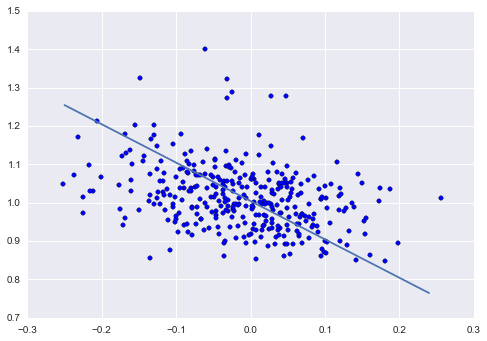

In [182]:
plt.scatter(pct_above,predpps)
plt.plot(pts,val)

In [627]:
clf=SGDClassifier(penalty='elasticnet',loss='log',alpha=.7)
clf.fit(X_new,y)
print clf.score(X_new,y)
plt.hist(clf.predict(X_new))
plt.show()

0.603509103666


In [616]:
from sklearn.linear_model import ElasticNetCV
clf=ElasticNetCV(cv=10,l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
clf.fit(X_new,y)
clf.score(X_new,y)

0.070617384671343486

In [9]:
result.coef_

array([[ 0.09699993,  0.04662496, -0.01978541, -0.09407258, -0.03858662]])

In [379]:
X['SHOT_DISTxCLOSE_DEF_DIST'] = X['SHOT_DIST']*X['CLOSE_DEF_DIST']
X['CS']=X['DRIBBLES']==0
X['REALLY_CLOSE']=X['SHOT_DIST']<=4

In [245]:
alphas=[.1,.08,.06,.05]
e_alphas = list()
e_alphas_r = list()  #holds average r2 error
for alpha in alphas:
    lasso = SGDClassifier(penalty='elasticnet',loss='log',alpha=alpha)
    err = list()
    err_2 = list()
    for tr_idx, tt_idx in kf:
        X_tr , X_tt = X_train.loc[tr_idx], X_train.loc[tt_idx]
        y_tr, y_tt = y_train.loc[tr_idx], y_train.loc[tt_idx]
        lasso.fit(X_tr, y_tr)
        y_hat = [x[1] for x in lasso.predict_proba(X_tt)]
        err_2.append(lasso.score(X_tt,y_tt))
        err.append(np.average((y_hat - y_tt)**2))
    e_alphas.append(np.average(err))
    e_alphas_r.append(np.average(err_2))

In [246]:
e_alphas_r


[0.60792596373312169,
 0.60712971111141401,
 0.60631368178885237,
 0.60535825391093201]

In [255]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
new_X=pd.DataFrame(poly.fit_transform(X))

In [256]:
new_X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1,1.9,17,7.7,13.5,6,3.61,32.3,14.63,25.65,11.4,289,130.9,229.5,102,59.29,103.95,46.2,182.25,81.0,36
1,1,3.2,0,23.5,1.4,26,10.24,0.0,75.20,4.48,83.2,0,0.0,0.0,0,552.25,32.90,611.0,1.96,36.4,676
2,1,3.5,0,25.7,1.3,26,12.25,0.0,89.95,4.55,91.0,0,0.0,0.0,0,660.49,33.41,668.2,1.69,33.8,676
3,1,3.6,19,24.7,14.5,27,12.96,68.4,88.92,52.20,97.2,361,469.3,275.5,513,610.09,358.15,666.9,210.25,391.5,729
4,1,3.7,0,25.2,1.0,24,13.69,0.0,93.24,3.70,88.8,0,0.0,0.0,0,635.04,25.20,604.8,1.00,24.0,576


In [410]:
lasso = SGDClassifier(penalty='elasticnet',loss='log',alpha=.1)
result=lasso.fit(X_close,y_close)
result.score(X_close,y_close)

0.63943891848612688

array([ 0.        ,  0.        ,  0.        , -0.17722361, -0.16257227,
        0.        ,  0.        ,  0.        ,  0.00897314,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.004391  ,  0.        ,  0.00933107,  0.        ,  0.        ,
       -0.01396977])

In [ ]:
plt.figsize = (15,10)
fig = plt.figure()     
ax = fig.add_subplot(111)
ax.plot(alphas, e_alphas, 'b-')
ax.plot(alphas, e_alphas_r, 'g--')
ax.set_xlabel("alpha")
plt.show()

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.cross_validation import KFold
from matplotlib import pyplot as plt

kf = KFold(X_train.shape[0], n_folds = 10,)


In [87]:
def vizualize(name,y,cuts):
    x=X[name]
    rang = np.linspace(min(x),max(x),cuts)
    count = []
    pct = []
    for index,val in enumerate(rang):
        if index==cuts-2:
            a=x[(x>=val) & (x<=rang[index+1])]
            b=y[(x>=val) & (x<=rang[index+1])]
            count.append(len(a)/float(len(y)))
            pct.append(sum(b)/float(max(1,len(b)))) 
        elif index<cuts-1:
            a=x[(x>=val) & (x<rang[index+1])]
            b=y[(x>=val) & (x<rang[index+1])]
            count.append(len(a)/float(len(y)))
            pct.append(sum(b)/float(max(1,len(b))))    
    output= list(rang)[0:cuts-1],count,pct
    fig, ax1 = plt.subplots()
    ax1.plot(output[0],output[1],color='b')
    ax1.set_xlabel(name)
    ax1.set_ylabel('Frequency', color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    ax2 = ax1.twinx()
    ax2.plot(output[0],output[2],color='r')
    ax2.set_ylabel('Shooting Percentage', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    plt.suptitle("Exploration of the variable " + name)
    plt.show()

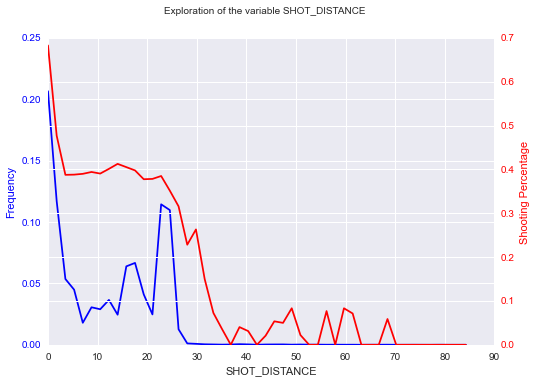

In [137]:
output = vizualize('SHOT_DISTANCE',y,50)

In [402]:
plt.scatter(X['SHOT_DIST'],X['SHOT_DISTANCE'],alpha=.2)
plt.show()

In [403]:
huh=all2013[(all2013.SHOT_DIST>20)&(all2013.SHOT_DISTANCE<3)]
huh.head()

,Unnamed: 0,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,DRIBBLES,FGM,FINAL_MARGIN,GAME_CLOCK,GAME_ID,GAME_ID.1,LOCATION,MATCHUP,PERIOD,PERIOD.1,PTS,PTS_TYPE,SHOT_CLOCK,SHOT_DIST,SHOT_NUMBER,SHOT_RESULT,TOUCH_TIME,W,GRID_TYPE,GAME_EVENT_ID,PLAYER_ID,PLAYER_ID.1,PLAYER_NAME,TEAM_ID,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,SHOT_CLOCK_ADJ,SHOT_CLOCK_REAL
82,5,"Gortat, Marcin",101162,2.5,0,1,-1,3:43,21300361,21300361,H,"DEC 16, 2013 - NYK vs. WAS",1,1,2,2,12.5,20.1,6,made,3.3,L,Shot Chart Detail,74,200745,200745,Andrea Bargnani,1610612752,3,39,Made Shot,Driving Reverse Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-8,4,1,1,219,12.5
621,20,"Mahinmi, Ian",101133,2.3,0,0,-5,7:53,21300739,21300739,A,"FEB 07, 2014 - POR @ IND",4,4,0,2,20.2,20.8,21,missed,3.5,L,Shot Chart Detail,433,200746,200746,LaMarcus Aldridge,1610612757,7,56,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,2,12,1,0,476,20.2
4817,5,"Outlaw, Travis",2566,14.4,0,0,14,0:24,21300201,21300201,H,"NOV 24, 2013 - LAL vs. SAC",4,4,0,2,13.0,26.3,6,missed,1.7,W,Shot Chart Detail,484,200761,200761,Shawne Williams,1610612747,0,14,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,9,-1,1,0,14,13.0
5146,4,"Anderson, James",202341,3.7,1,0,10,8:27,21301034,21301034,H,"MAR 22, 2014 - CHI vs. PHI",3,3,0,2,19.7,22.8,5,missed,1.0,W,Shot Chart Detail,322,2399,2399,Mike Dunleavy,1610612741,8,31,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-5,26,1,0,511,19.7
5700,5,"Teague, Jeff",201952,2.2,4,1,-8,2:30,21301166,21301166,A,"APR 09, 2014 - BOS @ ATL",2,2,2,2,19.0,25.3,6,made,4.3,L,Shot Chart Detail,218,200765,200765,Rajon Rondo,1610612738,2,34,Made Shot,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,12,12,1,1,154,19.0


In [309]:
from sklearn.feature_selection import RFE
estimator = LogisticRegression()
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)

In [153]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
X_new = SelectKBest(f_regression, k=10).fit_transform(X, y)
pd.DataFrame(X_new).head()

,0,1,2,3,4,5,6,7,8,9
0,7.7,6,1,0,0,0,1,0,0,1
1,23.5,26,0,1,0,1,0,0,0,1
2,25.7,26,0,1,0,1,0,0,0,1
3,24.7,27,1,1,0,1,0,0,0,1
4,25.2,24,0,1,0,1,0,0,0,1


In [386]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
clf = LassoCV()
# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.25)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

ImportError: cannot import name SelectFromModel

In [312]:
result = Lasso(alpha=.1).fit(X,y)

In [313]:
zip(X.columns,result.coef_)

[('CLOSE_DEF_DIST', 0.0),
 ('DRIBBLES', -0.0),
 ('SHOT_DIST', -0.0022926497236120369),
 ('TOUCH_TIME', -0.0),
 ('SHOT_DISTANCE', -0.009013933039435337),
 ('24+ ft.', 0.0),
 ('8-16 ft.', -0.0),
 ('Back Court Shot', -0.0),
 ('Less Than 8 ft.', 0.0),
 ('SHOT_DISTxCLOSE_DEF_DIST', 0.00039232346591208249),
 ('CS', 0.0),
 ('REALLY_CLOSE', 0.0)]

In [102]:
set(all2013['SHOT_ZONE_AREA'])

{'Back Court(BC)',
 'Center(C)',
 'Left Side Center(LC)',
 'Left Side(L)',
 'Right Side Center(RC)',
 'Right Side(R)'}

In [99]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
vec.fit_transform(all2013['SHOT_ZONE_AREA']).toarray()

AttributeError: 'str' object has no attribute 'iteritems'

In [217]:
all2013=pd.read_csv('merged_shots/merged_shots_13.csv')
all2013['OFF_HEIGHT']=[np.nan if str(x) == 'nan' else int(str(x)[0])*12 + int(str(x)[2:]) for x in all2013.off_height]
all2013['DEF_HEIGHT']=[np.nan if str(x) == 'nan' else int(str(x)[0])*12 + int(str(x)[2:]) for x in all2013.def_height]
all2013['HEIGHT_DIFF'] = all2013['OFF_HEIGHT'] - all2013['DEF_HEIGHT']
y=all2013['SHOT_MADE_FLAG']
all2013['SHOT_CLOCK_ADJ']=60*all2013.MINUTES_REMAINING+all2013.SECONDS_REMAINING
all2013['SHOT_CLOCK_REAL']=[b if np.isnan(a) else a for a,b in zip(all2013['SHOT_CLOCK'],all2013['SHOT_CLOCK_ADJ'])]
all2013['FAST_BREAK_OFF_TURN']=[1 if ((x==5) & (z>18)) else 0 for x,z in zip(all2013.ACTION_BEFORE,all2013.SHOT_CLOCK_REAL)]
#all2013['JUMP_SHOT']=[1 if x=='Jump Shot' else 0 for x in all2013.ACTION_TYPE]
X=all2013[['SHOT_CLOCK_REAL','CLOSE_DEF_DIST','DRIBBLES','TOUCH_TIME','SHOT_DISTANCE','HEIGHT_DIFF','FAST_BREAK_OFF_TURN']]
X['SHOT_DISTxCLOSE_DEF_DIST'] = X['SHOT_DISTANCE']*X['CLOSE_DEF_DIST']
X['HEIGHTxCLOSE_DEF_DIST'] = X['HEIGHT_DIFF']*X['CLOSE_DEF_DIST']
#X['SHOT_DISTxJUMP_SHOT']=X['SHOT_DISTANCE']*X['JUMP_SHOT']
X['CS']=X['DRIBBLES']==0
X['VERY_EARLY']=X.SHOT_CLOCK_REAL>23
X['EARLY']=(X.SHOT_CLOCK_REAL<=23)&(X.SHOT_CLOCK_REAL>18)
X['MID']=(X.SHOT_CLOCK_REAL<=18)&(X.SHOT_CLOCK_REAL>5)
X['LATE']=(X.SHOT_CLOCK_REAL<=5)
period = pd.get_dummies(all2013['PERIOD_y']).ix[:,1:]
X=X.join(period)
zonebasic = pd.get_dummies(all2013['SHOT_ZONE_BASIC']).ix[:,1:]
X=X.join(zonebasic)
shotrange = pd.get_dummies(all2013['SHOT_ZONE_RANGE']).ix[:,1:]
X=X.join(shotrange)
location = pd.get_dummies(all2013['LOCATION']).ix[:,1:]
X=X.join(location)
#action = pd.get_dummies(all2013['ACTION_TYPE'])
#X=X.join(action)
action = pd.get_dummies(all2013['PLAYER_NAME'])
X=X.join(action)
"""zone = pd.get_dummies(all2013['SHOT_ZONE_AREA']).ix[:,1:]

shottype = pd.get_dummies(all2013['SHOT_TYPE']).ix[:,1:]
#action = pd.get_dummies(all2013['ACTION_TYPE']).ix[:,1:]
zonebasic = pd.get_dummies(all2013['SHOT_ZONE_BASIC']).ix[:,1:]
shotrange = pd.get_dummies(all2013['SHOT_ZONE_RANGE']).ix[:,1:]
location = pd.get_dummies(all2013['LOCATION']).ix[:,1:]
#X=X.join(zone.join(zonebasic.join(shotrange.join(location.join(action)))))
X=X.join(zone.join(zonebasic.join(shotrange.join(location))))"""
print pd.get_dummies(all2013['SHOT_ZONE_AREA']).columns[0],pd.get_dummies(all2013['PERIOD_y']).columns[0],pd.get_dummies(all2013['ACTION_TYPE']).columns[0],pd.get_dummies(all2013['SHOT_ZONE_BASIC']).columns[0],pd.get_dummies(all2013['SHOT_ZONE_RANGE']).columns[0],pd.get_dummies(all2013['LOCATION']).columns[0]


/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documen

Back Court(BC) 1.0 Alley Oop Dunk Shot Above the Break 3 16-24 ft. A


/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [218]:
X_new=X.copy()
X_copy=X.dropna()
X_new=X.dropna()
y=y[X_new.index]
dist=4.5
X_new['CLOSE']=[1 if x<dist else 0 for x in X_copy.SHOT_DISTANCE]
cols = X_copy.columns
for col in cols:
    X_new['CLOSEx'+str(col)] = X_new['CLOSE']*X[col]

/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisonchase/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [219]:
wo=lasso.coef_[0]
hi=X_try.columns
X_try=X_new.copy()
lasso = LogisticRegression(penalty='l1',C=.01)
lasso.fit(X_try,y)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [220]:
zip(X_try.columns,lasso.coef_[0])

[('SHOT_CLOCK_REAL', 0.00029560145728092698),
 ('CLOSE_DEF_DIST', 0.069203451763232712),
 ('DRIBBLES', 0.033780923967620488),
 ('TOUCH_TIME', -0.043429721662820019),
 ('SHOT_DISTANCE', -0.034071596867911128),
 ('HEIGHT_DIFF', 0.019476770065409991),
 ('FAST_BREAK_OFF_TURN', 0.08970444841030227),
 ('SHOT_DISTxCLOSE_DEF_DIST', -0.0014453652285441275),
 ('HEIGHTxCLOSE_DEF_DIST', -0.003049790793070683),
 ('CS', 0.11320339811740295),
 ('VERY_EARLY', -0.18772115040715118),
 ('EARLY', 0.0),
 ('MID', 0.0091650947181024893),
 ('LATE', -0.23060024615112065),
 (1.0, 0.012180659807864782),
 (2.0, -0.010271053567355026),
 (3.0, 0.0),
 (4.0, -0.013071183639816863),
 (5.0, 0.0),
 (6.0, 0.0),
 (7.0, 0.0),
 ('Backcourt', 0.0),
 ('In The Paint (Non-RA)', -0.050912701734806394),
 ('Left Corner 3', 0.0),
 ('Mid-Range', 0.0),
 ('Restricted Area', 0.0),
 ('Right Corner 3', 0.0),
 ('24+ ft.', 0.034015017366379574),
 ('8-16 ft.', -0.11767793006764686),
 ('Back Court Shot', 0.0),
 ('Less Than 8 ft.', -0.2269231

In [221]:
lasso.score(X_try,y)

0.62714961011231629

In [203]:
huh=all2013[all2013.ACTION_TYPE=="Jump Shot"]
np.average(huh.SHOT_MADE_FLAG)


0.33426205402058662